In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,6)

import scipy
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

tfd = tfp.distributions

## Case 2: Aleatoric Uncertainty using data cleaning from Tancev

Oct 8 2021

In [2]:
# Define helper functions.
scaler = StandardScaler()
detector = IsolationForest(n_estimators=1000,  contamination="auto", random_state=0)

gal_df = pd.read_csv("Data/galaxies_near_clusters_0.3-0.6.csv") 
cluster_data = pd.read_csv("Data/cluster_data_0.3-0.6.csv")

# clear outliers
xname="sm_0.67"; yname="halo_mass"
xname="stellarmass"; yname="halo_mass"
x=cluster_data[xname]; 
y=cluster_data[yname];

unit_df =pd.DataFrame(data={"x":x,"y":y}) 
print(unit_df.shape)

# Scale data to zero mean and unit variance.
X_t = scaler.fit_transform(unit_df)

# Remove outliers.
detector = IsolationForest(n_estimators=1000,  contamination=0.05, random_state=0)
is_inlier = detector.fit_predict(X_t)
X_t = X_t[(is_inlier > 0),:]

inv_df=pd.DataFrame(data={xname:X_t[:,0],yname:X_t[:,1]})
X_t = scaler.inverse_transform(inv_df)
xc=X_t[:,0]
yc=X_t[:,1]
print(unit_df.shape)
print(inv_df.shape)

(287, 2)
(287, 2)
(272, 2)


In [3]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

negloglik = lambda y, rv_y: -rv_y.log_prob(y)
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(xc, yc, epochs=1000, verbose=False);

# Profit.
x_tst=np.arange(x.min(),x.max(),0.1)
x_tst=x_tst[:,None]

[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

2021-10-08 21:11:29.408836: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-08 21:11:29.409350: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-08 21:11:29.412935: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 32. Tune using inter_op_parallelism_threads for best performance.
2021-10-08 21:11:29.420845: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-10-08 21:11:29.473661: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization

[ 0.94317282 -2.99291412]
[ 2.7485191  -2.64130656]


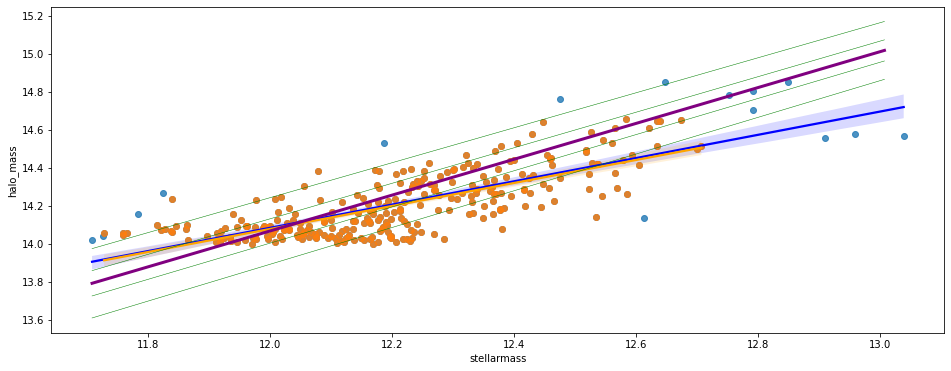

In [4]:
inv_df=pd.DataFrame(data={xname:X_t[:,0],yname:X_t[:,1]})
sns.regplot(x=xname,y=yname, data=cluster_data, line_kws={"color": "blue"})
sns.regplot(x=xname,y=yname, data=inv_df, line_kws={"color": "orange"})

plt.plot(x_tst, yhat.mean(),'purple', label='mean', linewidth=3);
plt.plot(x_tst, yhat.quantile(0.32),'g',linewidth=0.5);
plt.plot(x_tst, yhat.quantile(0.68),'g',linewidth=0.5);
plt.plot(x_tst, yhat.quantile(0.10),'g',linewidth=0.5);
plt.plot(x_tst, yhat.quantile(0.90),'g',linewidth=0.5);

This seemingly made very little difference, for a outlier set to contamination=0.05. Setting contamination=0.15 has a bigger effect.

## Folowing Probabilistic Bayesian Neural Networks

https://keras.io/examples/keras_recipes/bayesian_neural_networks/

Oct 8 2021

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp

In [6]:
def get_train_and_test_splits(train_size, batch_size=1):
    import tensorflow_datasets as tfds
    import Data
    dataset = (
        tfds.load(name="dataset", data_dir="./", 
                  as_supervised=False, split="train", download=False)
        .map(lambda x, y: (x, tf.cast(y, tf.float32)))
        .prefetch(buffer_size=dataset_size)
        .cache()
    )
    # We shuffle with a buffer the same size as the dataset.
    train_dataset = (
        dataset.take(train_size).shuffle(buffer_size=train_size).batch(batch_size)
    )
    test_dataset = dataset.skip(train_size).batch(batch_size)

    return train_dataset, test_dataset

In [7]:
hidden_units = [8, 8]
learning_rate = 0.001


def run_experiment(model, loss, train_dataset, test_dataset, num_epochs = 100):

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    x1 = train_dataset[0]
    x2 = train_dataset[1]
    y  = train_dataset[2]
    tx1 = test_dataset[0]
    tx2 = test_dataset[1]
    ty  = test_dataset[2]
    print("Start training the model...")
    #model.fit(x=[x1,x2], y=y, epochs=num_epochs, validation_data=[tx1,tx2,ty])
    model.fit(x=[x1,x2], y=y, epochs=num_epochs)
    print("Model training finished.")
    _, rmse = model.evaluate(x=[x1,x2], y=y, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")

    print("Evaluating model performance...")
    _, rmse = model.evaluate(x=[tx1,tx2], y=ty, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")

In [8]:
xname="sm_0.67"; yname="halo_mass"
xname="stellarmass"; yname="halo_mass"; x2name="central_sm"

gal_df = pd.read_csv("Data/galaxies_near_clusters_0.3-0.6.csv") 
cluster_data = pd.read_csv("Data/cluster_data_0.3-0.6.csv")
x=cluster_data[xname]; 
y=cluster_data[yname];
x2=cluster_data[x2name]

FEATURE_NAMES = [
    xname,
    x2name,
]

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(1,), dtype=tf.float32
        )
    return inputs

### Experiment 1: standard neural network
We create a standard deterministic neural network model as a baseline.

In [9]:
def create_baseline_model():
    inputs = create_model_inputs()
    input_values = [value for _, value in sorted(inputs.items())]
    features = keras.layers.concatenate(input_values)
    features = layers.BatchNormalization()(features)

    # Create hidden layers with deterministic weights using the Dense layer.
    for units in hidden_units:
        features = layers.Dense(units, activation="sigmoid")(features)
    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [11]:


x = np.asarray(x).astype('float32')
x2 = np.asarray(x2).astype('float32')
y = np.asarray(y).astype('float32')

n=150
x_tr=x[0:n]; x_te=x[n:]
x2_tr=x2[0:n]; x2_te=x[n:]
y_tr=y[0:n]; y_te=x[n:]
xx_tr=np.array([x_tr,x2_tr,y_tr]); xx_te=np.array([x_te,x2_te,y_te])
print("xx_tr: {}".format(xx_tr.shape))
print("y_tr: {}".format(y_tr.shape))

train_dataset = [x_tr, x2_tr, y_tr]
test_dataset = [x_te, x2_te, y_te]

#train_dataset = pd.DataFrame({xname:xx_tr,yname:y_tr})
#test_dataset = pd.DataFrame({xname:xx_te,yname:y_te})
#print(train_dataset)

#tr_df=tf.data.Dataset.from_tensor_slices(train_dataset)
#te_df=tf.data.Dataset.from_tensor_slices(test_dataset)

#tr_df=tf.convert_to_tensor(train_dataset, dtype=tf.float32)
#te_df=tf.convert_to_tensor(test_dataset, dtype=tf.float32)

#print(tr_df)
#print(te_df)
#dataset = train_dataset.enumerate()
#for element in dataset.as_numpy_iterator():
#  print(element)

xx_tr: (3, 150)
y_tr: (150,)


In [12]:

mse_loss = keras.losses.MeanSquaredError()
baseline_model = create_baseline_model()
baseline_model.summary()
run_experiment(baseline_model, mse_loss, train_dataset, test_dataset)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
central_sm (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
stellarmass (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2)            0           central_sm[0][0]                 
                                                                 stellarmass[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2)            8           concatenate[0][0]            

<AxesSubplot:>

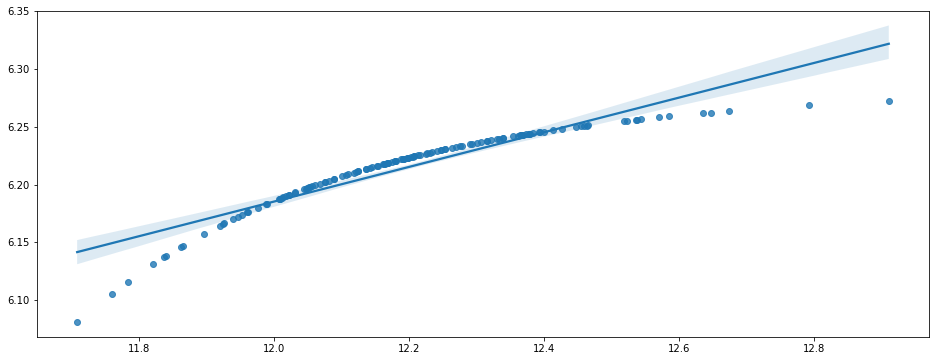

In [13]:
n_samples=30

y_fit = baseline_model.predict(x=[test_dataset[0], test_dataset[1]])
y_true = test_dataset[2]

sns.regplot(x=y_true, y=y_fit)

## Experiment 2: Bayesian neural network (BNN)

The object of the Bayesian approach for modeling neural networks is to capture the epistemic uncertainty, which is uncertainty about the model fitness, due to limited training data.

The idea is that, instead of learning specific weight (and bias) values in the neural network, the Bayesian approach learns weight distributions - from which we can sample to produce an output for a given input - to encode weight uncertainty.

Thus, we need to define prior and the posterior distributions of these weights, and the training process is to learn the parameters of these distributions.

In [14]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

def xposterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(2 * n, dtype=dtype),
            tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                tfd.Normal(
                    loc=t[..., :n], scale=1e-5 + tf.nn.softplus(c + t[..., n:])
                ),
                reinterpreted_batch_ndims=1)
            ),
        ]
    )
    return posterior_model

In [15]:
def create_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

We use the tfp.layers.DenseVariational layer instead of the standard keras.layers.Dense layer in the neural network model.

### Train BNN with a small training subset.

The epistemic uncertainty can be reduced as we increase the size of the training data. That is, the more data the BNN model sees, the more it is certain about its estimates for the weights (distribution parameters). Let's test this behaviour by training the BNN model on a small subset of the training set, and then on the full training set, to compare the output variances.

In [16]:
num_epochs = 500
tr_size = train_dataset[0].size
print(tr_size)

bnn_model_small = create_bnn_model(train_dataset[0].size)
run_experiment(bnn_model_small, mse_loss, train_dataset, test_dataset) 

150
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.


ValueError: Tensor conversion requested dtype float32 for Tensor with dtype float64: <tf.Tensor 'dense_variational/sequential/multivariate_normal_tri_l/dense_variational_sequential_multivariate_normal_tri_l_MultivariateNormalTriL_MultivariateNormalTriL/value/dense_variational_sequential_multivariate_normal_tri_l_MultivariateNormalTriL_MultivariateNormalTriL/sample/dense_variational_sequential_multivariate_normal_tri_l_MultivariateNormalTriL_MultivariateNormalTriL_chain_of_dense_variational_sequential_multivariate_normal_tri_l_MultivariateNormalTriL_MultivariateNormalTriL_shift_of_dense_variational_sequential_multivariate_normal_tri_l_MultivariateNormalTriL_MultivariateNormalTriL_scale_matvec_linear_operator/forward/dense_variational_sequential_multivariate_normal_tri_l_MultivariateNormalTriL_MultivariateNormalTriL_shift/forward/add:0' shape=(24,) dtype=float64>

Broken


### Experiment 3: probabilistic Bayesian neural network

So far, the output of the standard and the Bayesian NN models that we built is deterministic, that is, produces a point estimate as a prediction for a given example. We can create a probabilistic NN by letting the model output a distribution. In this case, the model captures the aleatoric uncertainty as well, which is due to irreducible noise in the data, or to the stochastic nature of the process generating the data.

In this example, we model the output as a IndependentNormal distribution, with learnable mean and variance parameters. If the task was classification, we would have used IndependentBernoulli with binary classes, and OneHotCategorical with multiple classes, to model distribution of the model output.

Since the output of the model is a distribution, rather than a point estimate, we use the negative loglikelihood as our loss function to compute how likely to see the true data (targets) from the estimated distribution produced by the model.

In [190]:
def create_probablistic_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # Create a probabilisticå output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
    distribution_params = layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [189]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)


num_epochs = 1000
prob_bnn_model = create_probablistic_bnn_model(train_size)
run_experiment(prob_bnn_model, negative_loglikelihood, train_dataset, test_dataset)

TypeError: Input 'b' of 'MatMul' Op has type float32 that does not match type float64 of argument 'a'.

Same kind of broken